## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        # img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        # cv2.imshow('img',img)
        # cv2.waitKey(500)

cv2.destroyAllWindows()

Define some utility functions

In [22]:
%matplotlib inline
import matplotlib.image as mpimg
def show_comparison(img_before, img_after, title_before='', title_after=''):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img_before)
    ax1.set_title(title_before, fontsize=50)
    ax2.imshow(img_after)
    ax2.set_title(title_after, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    return ax1, ax2

## Undistort image

(<matplotlib.axes._subplots.AxesSubplot at 0x7fbb92b064a8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fbb92a65668>)

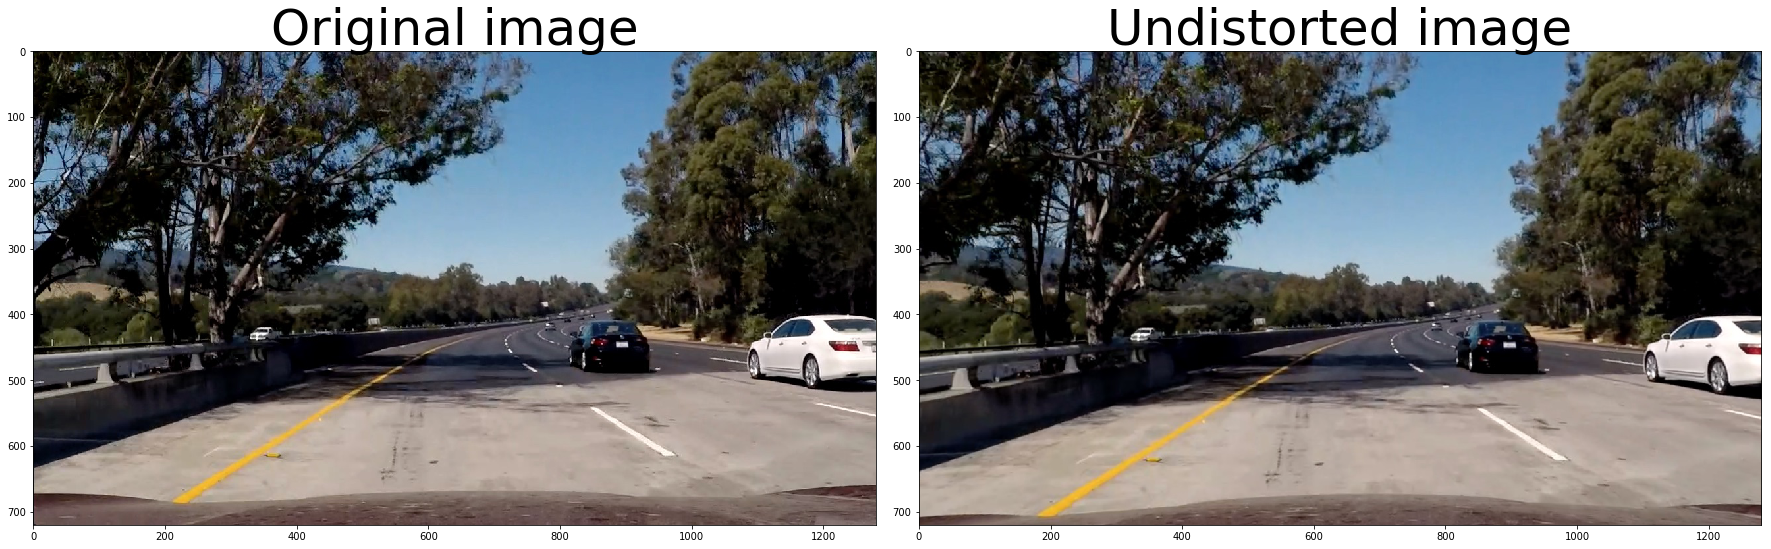

In [106]:
def cal_undistort(img):
    # Use cv2.calibrateCamera() and cv2.undistort()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (img.shape[1], img.shape[0]),None,None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # undist = np.copy(img)  # Delete this line
    return undist

test_img = mpimg.imread("../test_images/test5.jpg")
undist_img = cal_undistort(test_img)
show_comparison(test_img, undist_img, 'Original image', 'Undistorted image')


## Color/gradient threshold

(<matplotlib.axes._subplots.AxesSubplot at 0x7fbb87133780>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fbb870e82b0>)

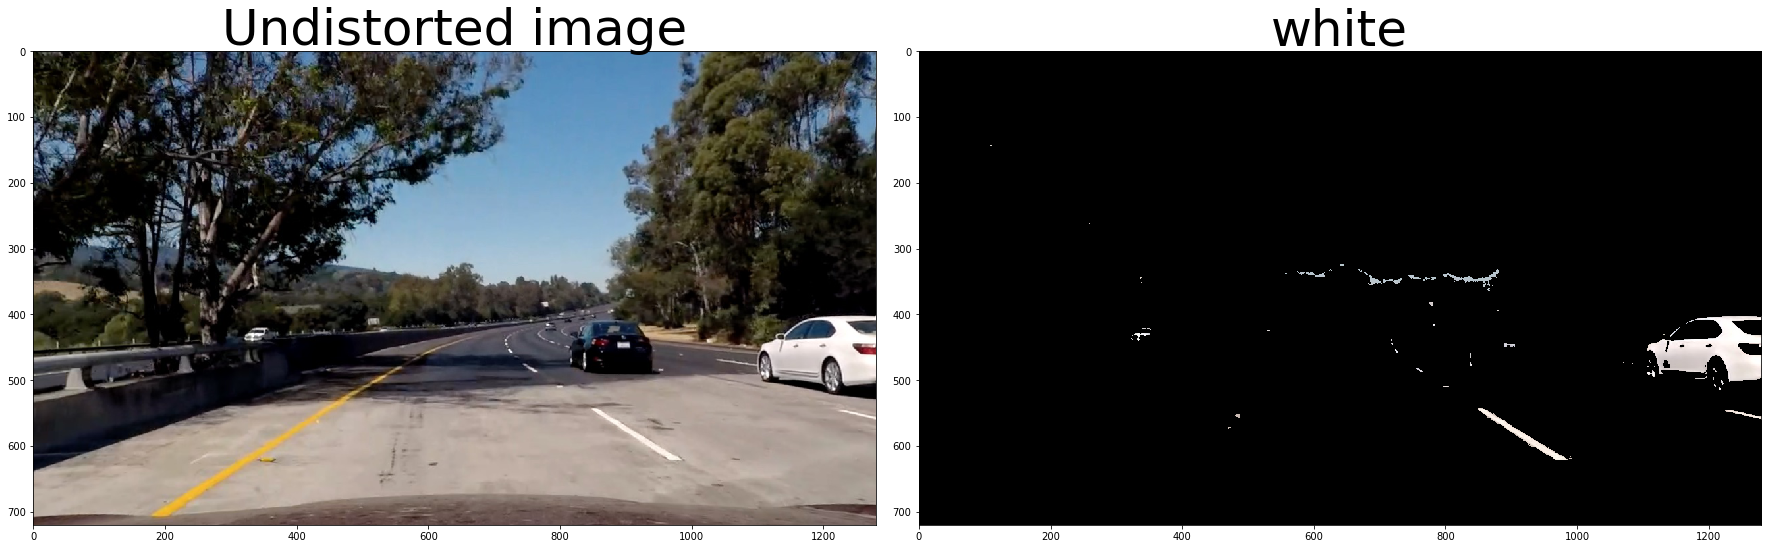

In [260]:
def color_threshold(img, h_thresh=(0, 255), s_thresh=(0, 255), v_thresh=(0, 255)):
    img = np.copy(img)
    # Convert to HSV color space and separate channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.float)
    h_channel = hsv[:, :, 0]
    s_channel = hsv[:, :, 1]
    v_channel = hsv[:, :, 2]
  
    # Threshold color channel
    color_binary = np.zeros_like(s_channel)
    color_binary[((s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])) &
                ((h_channel >= h_thresh[0]) & (h_channel <= h_thresh[1])) &
                ((v_channel >= v_thresh[0]) & (v_channel <= v_thresh[1]))] = 1
    return color_binary

def apply_hsv_mask(img, binary):
    res = img.copy()
    for i in range(img.shape[2]):
        res[:, :, i][binary != 1] = 0
    return res

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    img = np.copy(img)
    
    if orient == 'x':
        # Sobel x
        sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0) # Take the derivative in x
    elif orient == 'y':
        # Sobel y
        sobel = cv2.Sobel(img, cv2.CV_64F, 0, 1) # Take the derivative in y
    else:
        raise NameError('Please specify gradient orientation, x or y')
    # Absolute derivative to accentuate lines away from horizontal
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    # Threshold gradient
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    return grad_binary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return mag_binary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary =  np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return dir_binary

def pipe_line(image):
    img_g_mag = mag_thresh(image,3,(20,150))
    img_d_mag = dir_threshold(image,3,(.6,1.1))
    img_abs_x = abs_sobel_thresh(image,'x',5,(50,200))
    img_abs_y = abs_sobel_thresh(image,'y',5,(50,200))
    sobel_combined = np.zeros_like(img_d_mag)
    sobel_combined[((img_abs_x == 1) & (img_abs_y == 1)) | \
               ((img_g_mag == 1) & (img_d_mag == 1))] = 1
    return sobel_combined


# yellow_binary = color_threshold(undist_img,
#                                 h_thresh=(0, 50),
#                                 s_thresh=(80, 255),
#                                 v_thresh=(0, 255))
# yellow_masked = apply_hsv_mask(undist_img, yellow_binary)
# show_comparison(undist_img, yellow_masked, 'Undistorted image', 'yellow')

white_binary = color_threshold(undist_img,
                                h_thresh=(0, 255),
                                s_thresh=(0, 30),
                                v_thresh=(200, 255))
white_masked = apply_hsv_mask(undist_img, white_binary)
show_comparison(undist_img, white_masked, 'Undistorted image', 'white')


## Perspective transform

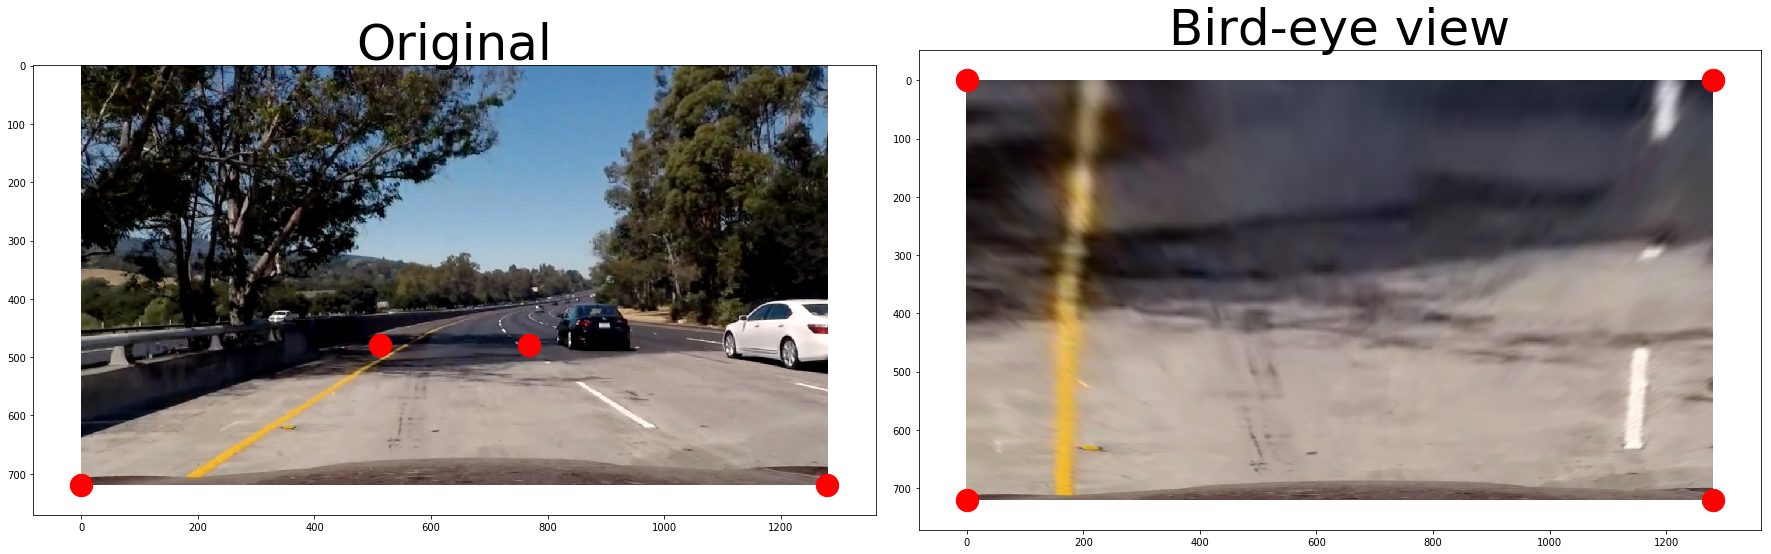

In [262]:
def warp_image(img,src,dst,img_size):
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    Minv = cv2.getPerspectiveTransform(dst, src)

    return warped, M, Minv

img_size = np.shape(undist_img)

ht_window = np.uint(img_size[0]/1.5)
hb_window = np.uint(img_size[0])
c_window = np.uint(img_size[1]/2)
ctl_window = c_window - .2*np.uint(img_size[1]/2)
ctr_window = c_window + .2*np.uint(img_size[1]/2)
cbl_window = c_window - 1*np.uint(img_size[1]/2)
cbr_window = c_window + 1*np.uint(img_size[1]/2)

src = np.float32([[cbl_window,hb_window],[cbr_window,hb_window],[ctr_window,ht_window],[ctl_window,ht_window]])

dst = np.float32([[0,img_size[0]],[img_size[1],img_size[0]],
                  [img_size[1],0],[0,0]])

warped,M_warp,Minv_warp = warp_image(undist_img,src,dst,(img_size[1],img_size[0]))

ax1, ax2 = show_comparison(undist_img, warped, 'Original', 'Bird-eye view')
ax1.scatter(src[:, 0], src[:, 1], s=500, color='r')
ax2.scatter(dst[:, 0], dst[:, 1], s=500, color='r')

## Find lane lines

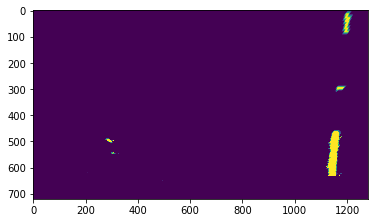

In [261]:
warped, _, _ = warp_image(white_binary, src, dst, (img_size[1],img_size[0]))
plt.imshow(warped)

/home/liangyuan/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


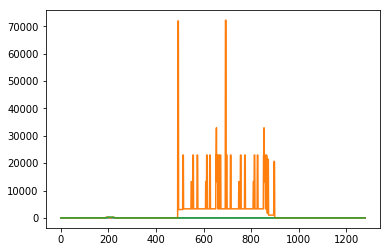

In [49]:
histogram = np.sum(warped[warped.shape[0]/2:,:], axis=0)
plt.plot(histogram)

In [50]:
binary_warped = warped
print(binary_warped.shape)
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
out_img = binary_warped * 255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
#     print(out_img.shape, (win_xleft_low,win_y_low), (win_xleft_high,win_y_high))
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    print(good_left_inds)
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
print(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

(720, 1280, 3)


/home/liangyuan/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


TypeError: expected non-empty vector for x